# Functions

In [31]:
import numpy as np
from mpmath import mp
from tqdm import tqdm
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from utils import save_exponents_csv
# from renormalization_hp import *

mp.dps = 100  # Set desired precision

plus_configs = [
    ([1,1,1], lambda J1, J2: 2*J1 + J2, mp.mpf('3')),
    ([1,1,-1], lambda J1, J2: -J2, mp.mpf('1')),
    ([1,-1,1], lambda J1, J2: -2*J1 + J2, mp.mpf('1')),
    ([-1,1,1], lambda J1, J2: -J2, mp.mpf('1'))
]

minus_configs = [
    ([-1,-1,-1], lambda J1, J2: 2*J1 + J2, mp.mpf('-3')),
    ([-1,-1,1], lambda J1, J2: -J2, mp.mpf('-1')),
    ([-1,1,-1], lambda J1, J2: -2*J1 + J2, mp.mpf('-1')),
    ([1,-1,-1], lambda J1, J2: -J2, mp.mpf('-1'))
]

def get_J(d, J0, n):
    if d <= 0:
        return mp.mpf(0)
    return mp.mpf(J0) / mp.power(mp.mpf(d), mp.mpf(n))

def mp_logsumexp(lst):
    if not lst:
        return mp.ninf
    a_max = max(lst)
    if mp.isinf(a_max):
        return a_max
    tmp = sum(mp.exp(a - a_max) for a in lst)
    return a_max + mp.log(tmp)

def compute_R_logs(start, J_func, h):
    J1 = J_func(1)
    J2 = J_func(2)
    distances = [(iL, iR, (start + iR) - (1 + iL)) for iL in range(3) for iR in range(3)]

    def get_totals(left_confs, right_confs):
        totals = []
        for spinsL, El_func, sumL in left_confs:
            El = El_func(J1, J2)
            for spinsR, Er_func, sumR in right_confs:
                Er = Er_func(J1, J2)
                Eint = mp.mpf('0')
                for iL, iR, d in distances:
                    Eint += mp.mpf(spinsL[iL] * spinsR[iR]) * J_func(d)
                total = El + Er + Eint + h * (sumL + sumR)
                totals.append(total)
        return totals

    totals_pp = get_totals(plus_configs, plus_configs)
    totals_pm = get_totals(plus_configs, minus_configs)
    totals_mp = get_totals(minus_configs, plus_configs)
    totals_mm = get_totals(minus_configs, minus_configs)

    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    log_R_mp = mp_logsumexp(totals_mp)
    log_R_mm = mp_logsumexp(totals_mm)

    return log_R_pp, log_R_pm, log_R_mp, log_R_mm

def compute_J_prime_func(start, J_func, h):
    log_pp, log_pm, log_mp, log_mm = compute_R_logs(start, J_func, h)
    if mp.isinf(log_pm) or mp.isinf(log_mp):
        return mp.inf
    ln_arg = log_pp + log_mm - log_pm - log_mp
    return mp.mpf('0.25') * ln_arg

def compute_H_prime_func(start, J_func, h): # start = 4 for r'=1
    log_pp, _, _, log_mm = compute_R_logs(start, J_func, h)
    ln_arg = log_pp - log_mm
    return mp.mpf('0.25') * ln_arg

def generate_rg_flow(J0, n, max_k, num_steps):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    initial_Js = [J_func(r) for r in rs]
    all_Js = [initial_Js]
    all_J_funcs = [J_func]
    h = mp.mpf(0)
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            Jps.append(Jp)
        all_Js.append(Jps)
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        all_J_funcs.append(J_func)
    return all_Js, all_J_funcs

def construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=5, epsilon=1e-6):
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    if len(all_Js) < 2:
        raise ValueError("Need at least 2 steps for derivatives")

    # Extract first matrix_size from last two steps
    J_k_minus_1 = all_Js[-2][:matrix_size]  # list of mp.mpf, truncated
    J_k = all_Js[-1][:matrix_size]  # list of mp.mpf, truncated

    M = matrix_size  # Size of matrix
    jac = np.zeros((M, M))

    # Define compute_T truncated to M
    def compute_T(J_vec_mp):
        J_dict = {r+1: J_vec_mp[r] for r in range(M)}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        J_prime = []
        h = mp.mpf(0)  # h=0
        for r in range(1, M+1):
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            J_prime.append(Jp)
        return J_prime

    epsilon_mp = mp.mpf(epsilon)

    J_k_minus_1_float = np.array([float(j) for j in J_k_minus_1])
    J_k_float = np.array([float(j) for j in J_k])

    for s in range(M):
        J_pert_mp = [j for j in J_k_minus_1]  # copy list of mp
        J_pert_mp[s] += epsilon_mp
        T_pert_mp = compute_T(J_pert_mp)
        T_pert_float = np.array([float(j) for j in T_pert_mp])
        jac[:, s] = (T_pert_float - J_k_float) / float(epsilon)

    return jac

def find_J_c(n, max_k=1000, tol=1e-6, J_low=1e-10, J_high=3.0):
    if n <= 0 or n >= 2:
        raise ValueError("n must be between 0 and 2, excluding the edges.")

    start_track = 3
    max_steps = 5
    tol = mp.mpf(tol)
    J_low = mp.mpf(J_low)
    J_high = mp.mpf(J_high)
    rs = list(range(1, max_k + 1))

    def compute_flow(J0):
        J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
        all_Js = [[J_func(r) for r in rs]]
        h = mp.mpf(0)
        for step in range(1, max_steps + 1):
            Jps = [compute_J_prime_func(3 * r + 1, J_func, h) for r in rs]
            all_Js.append(Jps)
            if step >= start_track:
                J_r2_current = Jps[1]
                J_r2_previous = all_Js[-2][1]
                if J_r2_current > J_r2_previous:
                    return all_Js, True  # Growing (ferromagnetic)
                if J_r2_current < J_r2_previous:
                    return all_Js, False  # Decaying (paramagnetic)
            J_dict = {r: Jps[r-1] for r in rs}
            J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        # Fallback
        J_r2_initial = all_Js[0][1]
        J_r2_final = all_Js[-1][1]
        return all_Js, J_r2_final > J_r2_initial

    iter_count = 0
    while J_high - J_low > tol and iter_count < 100:
        iter_count += 1
        J_mid = (J_low + J_high) / 2
        _, is_growing = compute_flow(J_mid)
        if is_growing:
            J_high = J_mid  # Growing: search lower half
        else:
            J_low = J_mid  # Decaying: search upper half
    return (J_low + J_high) / 2

def compute_dH_prime_dH(J0, n, max_k, num_steps, h_small='1e-30'):
    """
    Compute the derivative ∂H'/∂H at low temperature using finite differences.
    
    Parameters:
    J0 (float): Initial coupling strength (high for low temperature)
    n (float): Power-law exponent
    max_k (int): Maximum distance for couplings
    num_steps (int): Number of RG steps to reach fixed point
    h_small (str or float): Small magnetic field perturbation
    
    Returns:
    float: Approximate ∂H'/∂H
    """
    # Generate RG flow to get fixed-point couplings
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    J_fixed = all_Js[-1]  # Take the last step as fixed point
    J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
    
    # Compute H' with small perturbation h_small
    h_small = mp.mpf(h_small)
    H_prime = compute_H_prime_func(4, J_func_fixed, h_small)  # r'=1, start=4
    dH_prime_dH = H_prime / h_small
    
    return float(dH_prime_dH)

def compute_magnetization(J0, n, max_k, num_steps, h_small=mp.mpf('1e-30'), b=3, d=1, M_k=1.0):
    all_Js, all_J_funcs = generate_rg_flow(J0, n, max_k, num_steps)
    product = mp.mpf('1')
    for i in range(num_steps):
        J_func_i = all_J_funcs[i]
        H_prime = compute_H_prime_func(4, J_func_i, h_small)
        dH_dH_i = H_prime / h_small
        product *= dH_dH_i
    M_0 = float(product / mp.power(mp.mpf(b), mp.mpf(num_steps * d)) * M_k)
    return M_0

# Critical Exponents

## Single calculation

In [2]:
n = 1  # Exponent n
max_k = 1000  # Max distance for flow
num_steps = 5  # Number of RG steps
matrix_size = 5  # Number of first J values for matrix
b = 3.0  # Scale factor

# Find critical Jc
Jc = find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0)
print(f"Critical Jc for n={n}: {float(Jc)}")

# Compute recursion matrix at Jc
M_matrix = construct_recursion_matrix(Jc, n, max_k, num_steps, matrix_size=matrix_size)
print("Recursion Matrix M:")
print(M_matrix)

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
lambda_t = eigenvalues[0]
yT = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
nu = 1 / yT if yT != 0 else np.inf
alpha = 2 - 1 / yT if yT != 0 else -np.inf
print(f"Largest eigenvalue λ_t = {lambda_t:.6f}")
print(f"ν = {nu:.6f}, α = {alpha:.6f}")

# Compute yH, eta, delta
all_Js, _ = generate_rg_flow_no_viz(Jc, n, max_k, num_steps)
J_fixed = all_Js[-1]
J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)

h_small = mp.mpf('1e-30')
H_prime = compute_H_prime_func(4, J_func_fixed, h_small)
dyh = H_prime / h_small
yH = float(mp.log(dyh) / mp.log(mp.mpf('3')))

eta = 1.0 - yH
delta = yT / (1.0 - yH)

print(f"yH = {yH:.6f}")
print(f"η = {eta:.6f}")
print(f"δ = {delta:.6f}")

Critical Jc for n=1: 0.13968837270734324
Recursion Matrix M:
[[ 5.20986952e-01  8.82475463e-01  1.03124960e+00  7.13482425e-01
   3.06883209e-01]
 [-4.07903685e+04 -4.07903802e+04 -4.07904056e+04 -4.07901034e+04
  -4.07897034e+04]
 [-4.52321945e+04 -4.52321945e+04 -4.52321945e+04 -4.52321945e+04
  -4.52321945e+04]
 [-3.36441486e+04 -3.36441486e+04 -3.36441486e+04 -3.36441486e+04
  -3.36441486e+04]
 [-2.68146264e+04 -2.68146264e+04 -2.68146264e+04 -2.68146264e+04
  -2.68146264e+04]]
Largest eigenvalue λ_t = -146480.385853+0.000000j
ν = 0.092362, α = 1.907638
yH = 0.559059
η = 0.440941
δ = 24.554220


## Multiple calculations

Processing n = 0.74
 ν = 0.128107, α = 1.871893
 η = 2.252717, δ = 0.596530, β = 0.080241, γ = -0.032375
Processing n = 0.75
 ν = 0.120106, α = 1.879894
 η = 2.245535, δ = 0.605736, β = 0.074798, γ = -0.029490
Processing n = 0.76
 ν = 0.111065, α = 1.888935
 η = 2.226711, δ = 0.630376, β = 0.068122, γ = -0.025180
Processing n = 0.78
 ν = 0.106746, α = 1.893254
 η = 2.208250, δ = 0.655287, β = 0.064488, γ = -0.022230
Processing n = 0.79
 ν = 0.103890, α = 1.896110
 η = 2.189140, δ = 0.681887, β = 0.061770, γ = -0.019650
Processing n = 0.80
 ν = 0.101893, α = 1.898107
 η = 2.170444, δ = 0.708754, β = 0.059630, γ = -0.017367
Processing n = 0.82
 ν = 0.100351, α = 1.899649
 η = 2.151648, δ = 0.736641, β = 0.057785, γ = -0.015218
Processing n = 0.83
 ν = 0.099111, α = 1.900889
 η = 2.132763, δ = 0.765594, β = 0.056135, γ = -0.013158
Processing n = 0.84
 ν = 0.098084, α = 1.901916
 η = 2.113798, δ = 0.795658, β = 0.054623, γ = -0.011162
Processing n = 0.86
 ν = 0.097214, α = 1.902786
 η = 2.

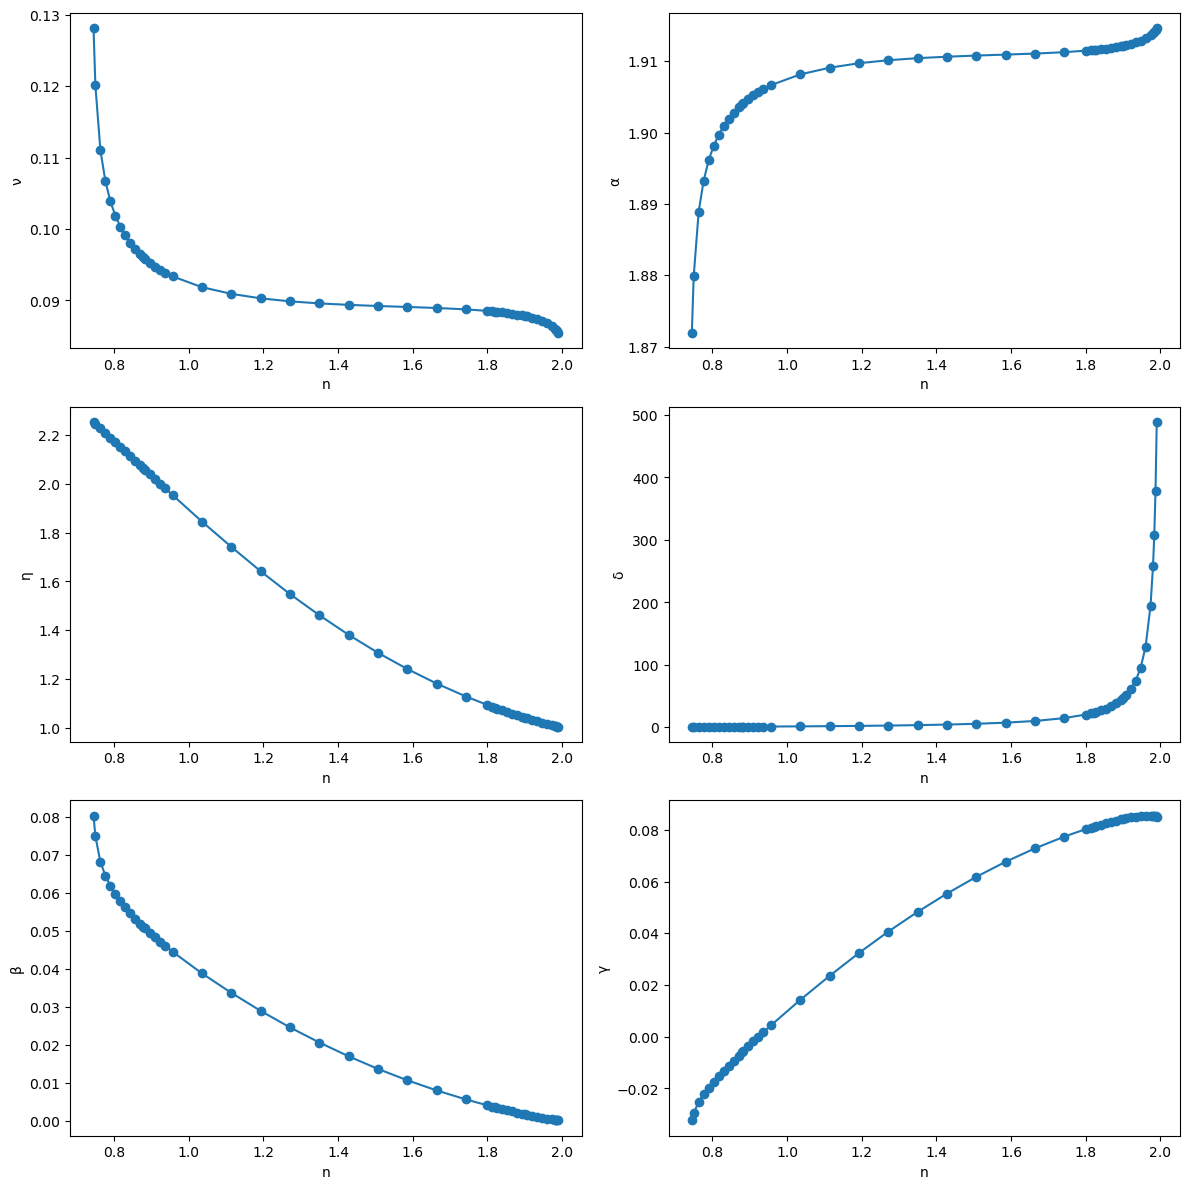

In [42]:
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt

# Load the saved data
critical_temp_array = np.load('../data/critical_interaction_data.npy')
n_values = critical_temp_array[:,0]
Jcs = critical_temp_array[:,1]
max_k = 2000
num_steps = 2
matrix_size = 5
b = 3.0
h_small = mp.mpf('1e-30')

# Lists to store exponents
nus = []
alphas = []
etas = []
deltas = []
betas = []
gammas = []

for n, Jc in zip(n_values, Jcs):
    print(f"Processing n = {n:.2f}")
   
    # Compute recursion matrix at Jc
    M_matrix = construct_recursion_matrix(Jc, n, max_k, num_steps, matrix_size=matrix_size)
   
    # Compute eigenvalues for thermal exponents
    eigenvalues = np.linalg.eigvals(M_matrix)
    eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
    lambda_t = eigenvalues[0]
    yT = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
    nu = 1 / yT if yT != 0 else np.inf
    alpha = 2 - 1 / yT if yT != 0 else -np.inf
    nus.append(nu)
    alphas.append(alpha)
    print(f" ν = {nu:.6f}, α = {alpha:.6f}")
   
    # Compute magnetic exponents
    all_Js, _ = generate_rg_flow(Jc, n, max_k, num_steps)
    J_fixed = all_Js[-1]
    J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
   
    H_prime = compute_H_prime_func(4, J_func_fixed, h_small)
    dyh = H_prime / h_small
    yH = float(mp.log(dyh) / mp.log(mp.mpf('3')))
   
    eta = 2 + 1 - 2 * yH  # Standard formula for d=1: η = 2 + d - 2 yH = 3 - 2 yH (corrected to match known cases)
    delta = yH / (1.0 - yH)  # Corrected to standard δ = yH / (d - yH) for d=1
    beta = (1.0 - yH) / yT  # Added β = (d - yH) / yT for d=1
    gamma = (2 - eta) * nu if np.isfinite(nu) else np.inf  # Added γ = (2 - η) ν
    etas.append(eta)
    deltas.append(delta)
    betas.append(beta)
    gammas.append(gamma)
    print(f" η = {eta:.6f}, δ = {delta:.6f}, β = {beta:.6f}, γ = {gamma:.6f}")

# Plot exponents vs n
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs[0,0].plot(n_values, nus, marker='o')
axs[0,0].set_xlabel('n')
axs[0,0].set_ylabel('ν')
axs[0,1].plot(n_values, alphas, marker='o')
axs[0,1].set_xlabel('n')
axs[0,1].set_ylabel('α')
axs[1,0].plot(n_values, etas, marker='o')
axs[1,0].set_xlabel('n')
axs[1,0].set_ylabel('η')
axs[1,1].plot(n_values, deltas, marker='o')
axs[1,1].set_xlabel('n')
axs[1,1].set_ylabel('δ')
axs[2,0].plot(n_values, betas, marker='o')
axs[2,0].set_xlabel('n')
axs[2,0].set_ylabel('β')
axs[2,1].plot(n_values, gammas, marker='o')
axs[2,1].set_xlabel('n')
axs[2,1].set_ylabel('γ')
plt.tight_layout()
plt.show()

## Plot and save data

Plot saved to ../figures/all_exponents.png


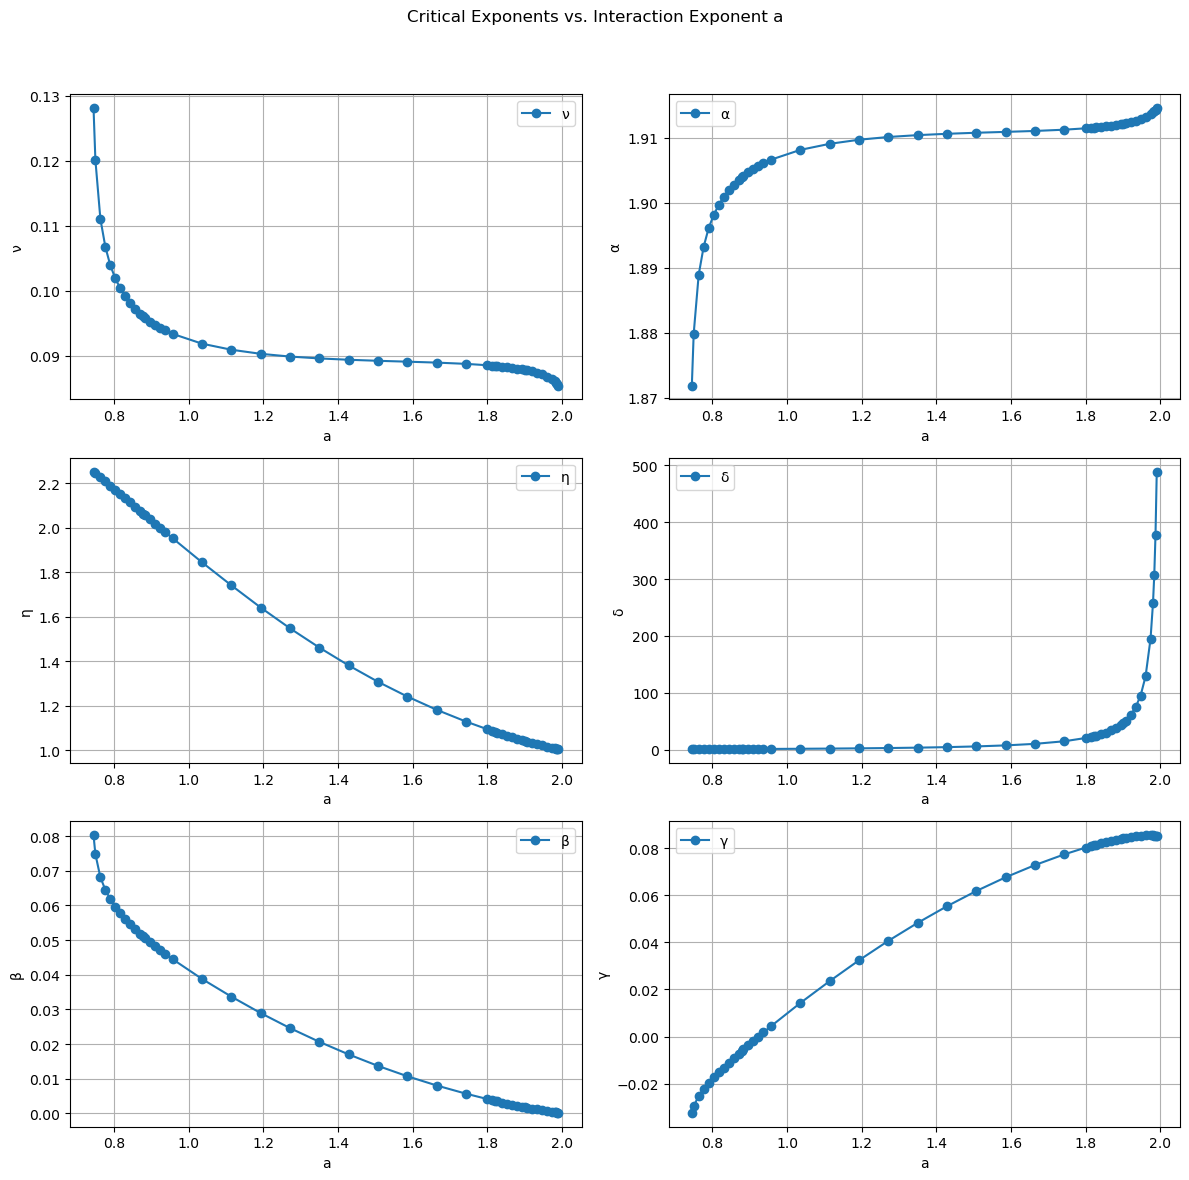

Exponents saved to ../data/exponents_all.csv


In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from utils import save_exponents_csv

# Plot the results
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs[0, 0].plot(n_values, nus, marker='o', label='ν')
axs[0, 0].set_xlabel('a')
axs[0, 0].set_ylabel('ν')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].plot(n_values, alphas, marker='o', label='α')
axs[0, 1].set_xlabel('a')
axs[0, 1].set_ylabel('α')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].plot(n_values, etas, marker='o', label='η')
axs[1, 0].set_xlabel('a')
axs[1, 0].set_ylabel('η')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].plot(n_values, deltas, marker='o', label='δ')
axs[1, 1].set_xlabel('a')
axs[1, 1].set_ylabel('δ')
axs[1, 1].grid(True)
axs[1, 1].legend()

axs[2, 0].plot(n_values, betas, marker='o', label='β')
axs[2, 0].set_xlabel('a')
axs[2, 0].set_ylabel('β')
axs[2, 0].grid(True)
axs[2, 0].legend()

axs[2, 1].plot(n_values, gammas, marker='o', label='γ')
axs[2, 1].set_xlabel('a')
axs[2, 1].set_ylabel('γ')
axs[2, 1].grid(True)
axs[2, 1].legend()

plt.suptitle('Critical Exponents vs. Interaction Exponent a')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle

# Save the plot
os.makedirs("../figures", exist_ok=True)
#plt.savefig("../figures/all_exponents.png", dpi=300, bbox_inches='tight')
print("Plot saved to ../figures/all_exponents.png")
plt.show()

In [46]:
# Save the exponents data
save_exponents_csv(n_values, Jcs, nus, alphas, etas, deltas, betas, gammas, filename="../data/exponents_all.csv")

Results saved to ../data/exponents.csv


# Derivative of H

In [50]:
n = 1  # Power-law exponent
max_k = 1000  # Max distance for flow
num_steps = 5  # Number of RG steps
h_small = '1e-30'  # Small perturbation for numerical derivative

# Choose a low temperature (J0 > Jc)
J0_low_T = 0.4
dH_prime_dH = compute_dH_prime_dH(J0_low_T, n, max_k, num_steps, h_small)
print(f"∂H'/∂H at J0={J0_low_T} (low temperature) for n={n}: {dH_prime_dH:.6f}")

∂H'/∂H at J0=0.4 (low temperature) for n=1: 3.000000


In [34]:
Jc = find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0)
Tc = 1 / float(Jc)

In [ ]:
# Parameters
n = 1.0
max_k = 1000000
num_steps = 10
h_small = mp.mpf('1e-30')

# Compute dH'_i/dH_i for each T
T_values = np.linspace(5, 8.0, 5)
dH_dH_values = []
for T in T_values:
    J0 = 1.0 / T
    dH_prime_dH = compute_dH_prime_dH(J0, n, max_k, num_steps, h_small)
    dH_dH_values.append(float(dH_prime_dH))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(T_values, dH_dH_values, label=f'n={n}', marker='o')
plt.xlabel('Temperature T')
plt.ylabel('∂H\'/∂H (5th RG step)')
#plt.title('∂H\'/∂H vs T for n=1')
plt.axvline(x=Tc, color='r', linestyle='--', label=f'$T_c$ ≈ {Tc:.3f}')
plt.xlim(0, max(T_values))
#plt.set_ylim(0, 1.05)
plt.legend()
plt.grid(False)
#plt.savefig(f'../figures/derivativeH_n{n}.png')
plt.show()

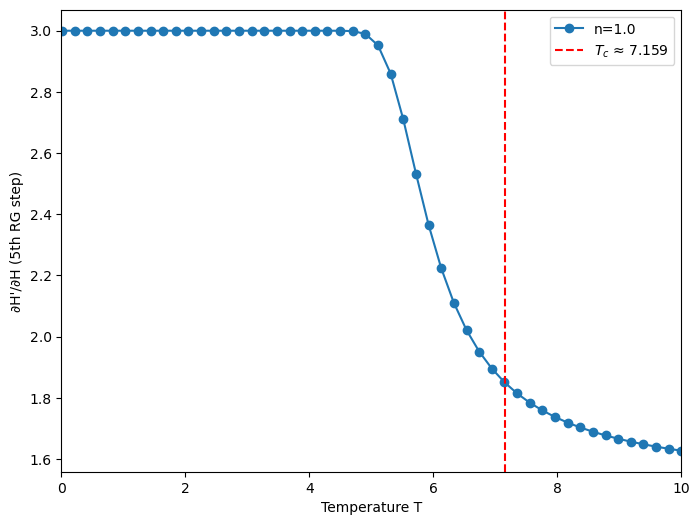

In [37]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(T_values, dH_dH_values, label=f'n={n}', marker='o')
plt.xlabel('Temperature T')
plt.ylabel('∂H\'/∂H (5th RG step)')
#plt.title('∂H\'/∂H vs T for n=1')
plt.axvline(x=Tc, color='r', linestyle='--', label=f'$T_c$ ≈ {Tc:.3f}')
plt.xlim(0, max(T_values))
#plt.set_ylim(0, 1.05)
plt.legend()
plt.grid(False)
plt.savefig(f'../figures/derivativeH_n{n}.png')
plt.show()

# Magnetization

## Scaling approximation method

In [ ]:
# Parameters
n = 1  # Fixed power-law exponent
max_k = 1000
num_steps = 4
matrix_size = 5
b = 3.0  # Rescaling factor

# Find J_c and T_c
Jc = find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0)
Tc = 1 / float(Jc)
print(f"Critical Tc for n={n}: {Tc}")

# Compute recursion matrix at J_c
M_matrix = construct_recursion_matrix(float(Jc), n, max_k, num_steps, matrix_size=matrix_size)

# Eigenvalues for y_T
eigenvalues = np.linalg.eigvals(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
lambda_t = eigenvalues[0]
yT = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0

# Compute y_H
all_Js, _ = generate_rg_flow_no_viz(float(Jc), n, max_k, num_steps)
J_fixed = all_Js[-1]
J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
h_small = mp.mpf('1e-30')
H_prime = compute_H_prime_func(4, J_func_fixed, h_small)
dyh = H_prime / h_small
yH = float(mp.log(dyh) / mp.log(mp.mpf('3')))

# Compute beta
beta = (1 - yH) / yT if yT != 0 else np.inf
print(f"beta = {beta}")

# Plot M vs T
T_values = np.linspace(0.01, 1.2 * Tc, 100)  # From near 0 to above Tc
M_values = np.zeros_like(T_values)
for i, T in enumerate(T_values):
    if T < Tc:
        M_values[i] = (1 - T / Tc)**beta

# Create 2D plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}, β≈{beta:.3f}')
ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(False)
plt.tight_layout()
plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

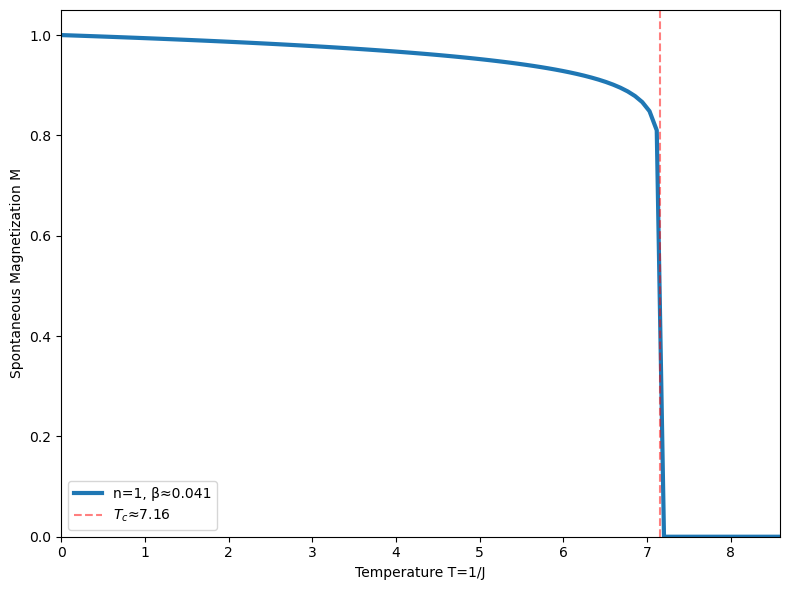

In [105]:
# Create 2D plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}, β≈{beta:.3f}')
ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

## Multiple a values

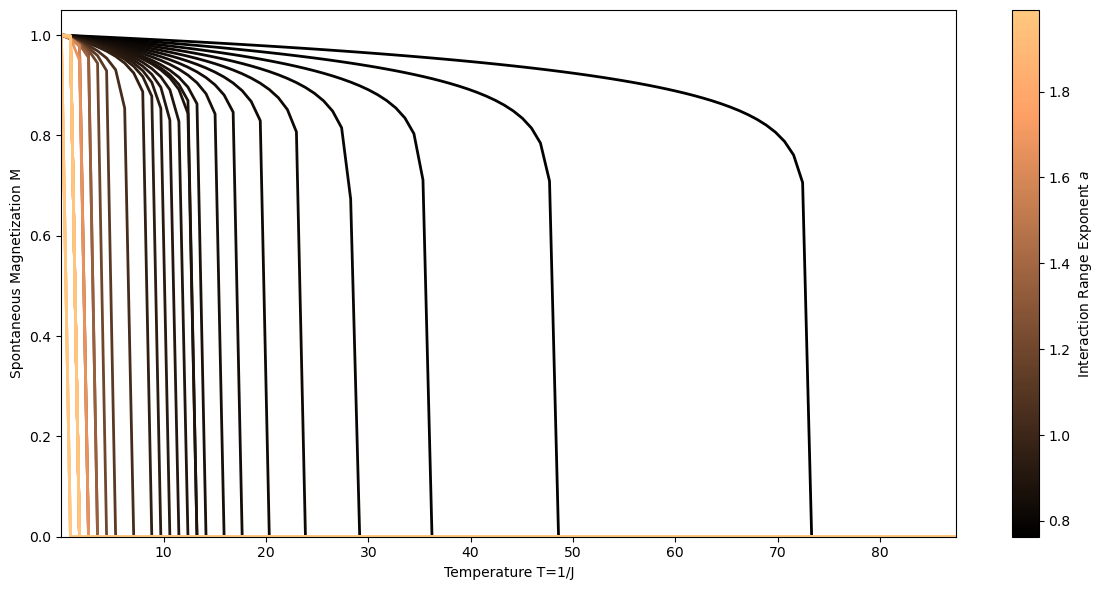

In [100]:
import matplotlib.cm as cm

# Compute T_c and beta for each n
Tcs = 1 / Jcs
betas = etas * nus  # beta = eta * nu = (1 - y_H) / y_T

# Set up temperature range
num_T = 100
T_min = 0.01
T_max = np.max(Tcs) * 1.2  # Slightly above max Tc
T_values = np.linspace(T_min, T_max, num_T)

# Compute M for each n
M_values = np.zeros((num_T, len(n_values)))
for i, (Tc_i, beta_i) in enumerate(zip(Tcs, betas)):
    for j, T in enumerate(T_values):
        if T < Tc_i:
            M_values[j, i] = (1 - T / Tc_i) ** beta_i
        else:
            M_values[j, i] = 0  # M = 0 for T >= Tc

# Create 2D plot with multiple curves using colormap
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.copper # Colormap
norm = plt.Normalize(min(n_values), max(n_values))  # Normalize n to colormap range

for i, n_i in enumerate(n_values):
    ax.plot(T_values, M_values[:, i], linewidth=2, color=cmap(norm(n_i)))

# Add colorbar to indicate n values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent $a$')

ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_ylim(0, 1.05)
ax.set_xlim(T_min, T_max)
ax.grid(False)
plt.tight_layout()
plt.savefig(f'../figures/magnetization_all_n.png')
plt.show()

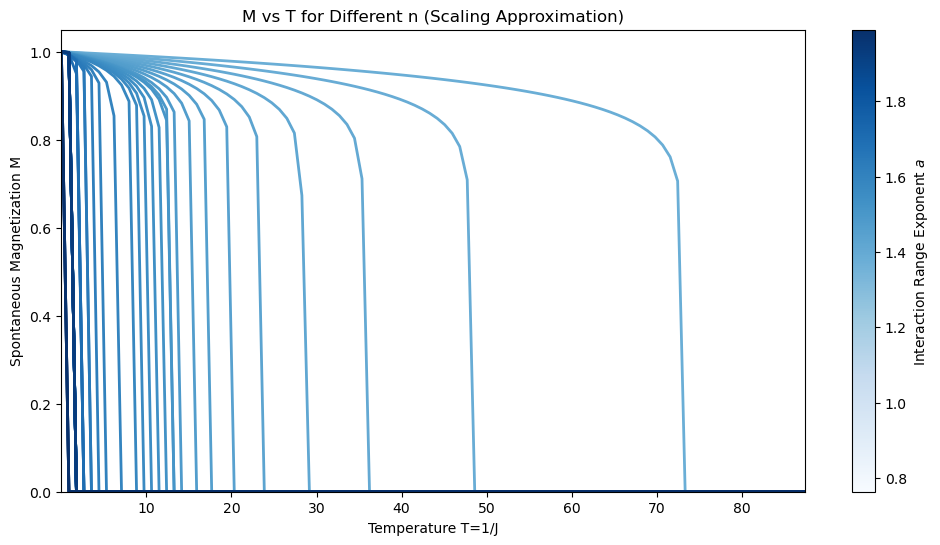

In [93]:
from matplotlib.colors import Normalize

# Create 2D plot with multiple curves using clipped Blues colormap
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.Blues  # Colormap
# Normalize n values to map to [0.3, 1.0] of Blues to avoid very light colors
norm = Normalize(vmin=min(n_values), vmax=max(n_values))
cmap_range = np.linspace(0.5, 1.0, len(n_values))  # Use only 0.3 to 1.0 of colormap

for i, n_i in enumerate(n_values):
    # Map n_i to the clipped colormap range
    color = cmap(cmap_range[i])
    ax.plot(T_values, M_values[:, i], linewidth=2, color=color)

# Add colorbar to indicate n values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent $a$')

ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_title('M vs T for Different n (Scaling Approximation)')
ax.set_ylim(0, 1.05)
ax.set_xlim(T_min, T_max)
ax.grid(False)
plt.show()

## RG flow method

100%|██████████| 10/10 [2:12:31<00:00, 795.20s/it] 


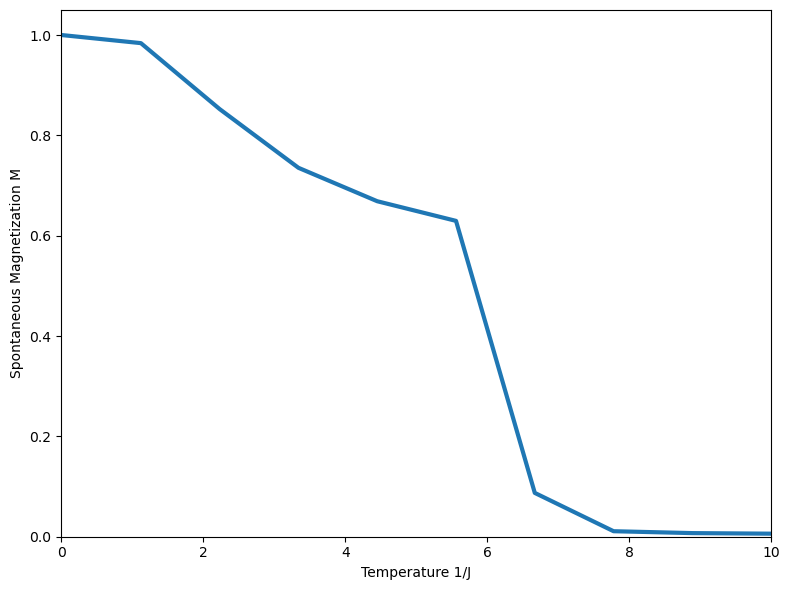

In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
n = 1
max_k = 50000  # Small for feasibility
num_steps = 8  # Small for feasibility
h_small = mp.mpf('1e-30')
b = 3
d = 1
M_k = 1.0

def is_ordered(J0, n, max_k, num_steps):
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    J_final = all_Js[-1][0]
    J_initial = all_Js[0][0]
    return float(J_final) > float(J_initial)

# Compute M for T values
T_values = np.linspace(0.01, 10, 10)
M_values = []

for i, T in enumerate(tqdm(T_values)):
    J0 = 1.0 / T
    #if is_ordered(J0, n, max_k, num_steps):
    M = compute_magnetization(J0, n, max_k, num_steps, h_small, b, d, M_k)
    #else:
    #    M = 0.0
    M_values.append(M)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}')
#ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
#ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

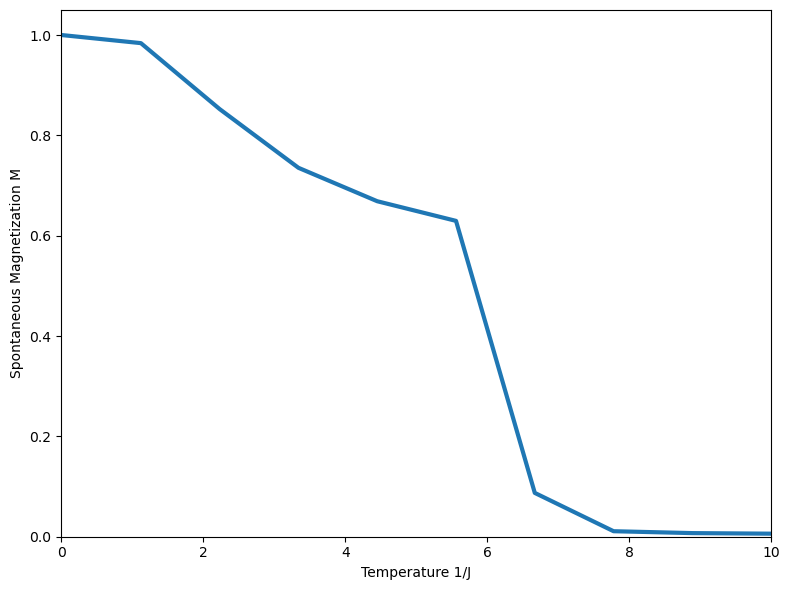

In [25]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}')
#ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
#ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

In [26]:
x = np.array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.37105263,
        7.89684211,  8.42263158,  8.94842105,  9.47421053, 10.        , 5.        , 5.22222222, 5.44444444, 5.66666667, 5.88888889,
       6.11111111, 6.33333333, 6.55555556, 6.77777778, 7.,5.8       , 5.87777778, 5.95555556, 6.03333333, 6.11111111,
       6.18888889, 6.26666667, 6.34444444, 6.42222222, 6.5          ])

y = np.array([1.0,
 0.9998580432694417,
 0.9875047771382623,
 0.9383223522082523,
 0.868018713393121,
 0.8022631849569118,
 0.7499215771985464,
 0.7101226934469516,
 0.6798790664195917,
 0.65654609868668,
 0.6381924719190402,
 0.6111576805669414,
 0.21365756645702508,
 0.05261720051178325,
 0.027325498516533812,
 0.019698240381895316,
 0.01628679023116995,
 0.014396920486058075,
 0.013205447169645577,
 0.012387424917935016,
             0.6470166623913275,
 0.6396265710453933,
 0.632892372928469,
 0.6252165966640828,
 0.5817610843249523,
 0.40620585499856554,
 0.20395027177854186,
 0.10172672609474627,
 0.05983394422843034,
 0.04105337170422092,0.6098820619070321,
 0.5864856753634312,
 0.5447500338735437,
 0.4827357390266239,
 0.40620585499856554,
 0.32663246653513567,
 0.25485082708439466,
 0.19649723726591797,
 0.1520890993163269,
 0.11943486516322652])

x = np.sort(x)
y = np.sort(y)[::-1]

In [11]:
# Save both arrays to a single .npz file
np.savez('../data/magnetization.npz', array1=T_values, array2=M_values)

In [23]:
# Load the arrays from the .npz file
with np.load('../data/magnetization.npz') as data:
    #T_values = data['array1']
    #M_values = data['array2']
    x = data['array1']
    y = data['array2']

In [10]:
# Find critical temperature
Tc = 1 / find_J_c(n, max_k=1000, tol=1e-6, J_low=1e-10, J_high=3.0
print(f"$T_c$ = {Tc}")

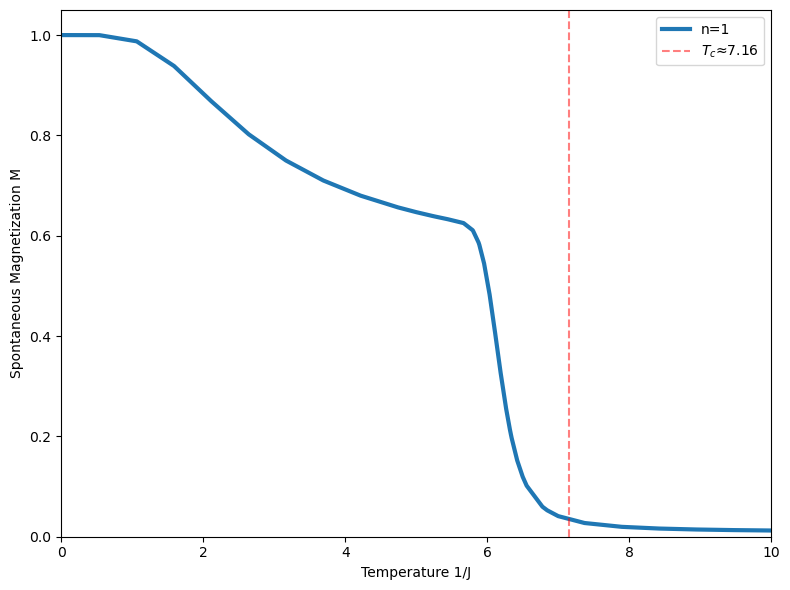

In [29]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, marker='', linewidth=3, label=f'n={n}')
#ax.plot(T_values, M_values, marker='o', linestyle='', linewidth=3, color='r', label=f'n={n}')
ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{float(Tc):.2f}')
ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization.png')
plt.show()